In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm

In [2]:
figsize=(12, 5)

In [3]:
def calculate_mean_betty(df: pd.DataFrame, array, dim=None):
    """
    Calculate mean betty numbers
    
    Parameters:
    -----------
    df : DataFrame with columns ['Birth', 'Death', 'Dimension', 'Space']
    
    array : list or np.array
        Array of values
        
    dim : int or None
        Dimension of topological space
        If that's None< that will be maximal dimension from dfs['Dimension']
    
    Returns:
    --------
    res : np.array shape (len(array), dim)
        Array of 
    """
    if dim is None:
        dim = df['Dimension'].max()
    res = np.zeros([len(array), dim])
    for i in range(len(array)):
        val = array[i]
        dfi = df[(df['Birth'] <= val)&(df['Death'] > val)]
        dfi = dfi.groupby(['Space', 'Dimension'], as_index=False).count()[['Space', 'Dimension', 'Birth']]
        dfi = dfi.groupby('Dimension', as_index=False).mean()
        index = dfi['Dimension'].values
        vals = dfi['Birth'].values
        res[i, index] = vals
    return res

In [4]:
def calculate_mean_EC(df: pd.DataFrame, array):
    """
    Calculate mean betty numbers
    
    Parameters:
    -----------
    df : DataFrame with columns ['Birth', 'Death', 'Dimension', 'Space']
    
    array : list or np.array
        Array of values
        
    
    Returns:
    --------
    res : np.array length len(array)
        Array of 
    """
    res = np.zeros(len(array))
    for i in range(len(array)):
        val = array[i]
        dfi = df[(df['Birth'] <= val)&(df['Death'] > val)][['Space', 'Dimension', 'Birth']]
        dfi = dfi.groupby(['Space', 'Dimension'], as_index=False).count()
        dfi.columns = ['Space', 'Dimension', 'Count']
        dfi['Summand EC'] = (-1)**dfi['Dimension'] * dfi['Count']
        dfi = dfi.groupby('Space', as_index=False).sum()['Summand EC']
        res[i] = dfi.mean()
    res[np.isnan(res)] = 0
    return res

In [5]:
def catch_zeros(x, y):
    # returns all zero arguments for graph y(x)
    ids = np.where(y[1:]*y[:-1] <= 0)[0]
    zeros = []
    for i in ids:
        x0, x1 = x[i], x[i+1]
        y0, y1 = abs(y[i]), abs(y[i+1])
        xz = x0 + (x1 - x0)*y0/(y0 + y1)
        zeros.append(xz)
    return np.array(zeros)

# Analyze lab_cubical_tessellation_on_torus3d

In [6]:
size = 69
experiments = 100
filename = 'lab-results/lab_cubical_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
df = pd.read_csv(filename)
df.shape

(12085306, 4)

In [7]:
df_gc = df[df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

giant_births_dim1 = df_gc[df_gc['Dimension'] == 1][['Space', 'Birth']]
giant_births_dim1 = giant_births_dim1.sort_values(['Space', 'Birth'])
giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim1_mean = giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

giant_births_dim2 = df_gc[df_gc['Dimension'] == 2][['Space', 'Birth']]
giant_births_dim2 = giant_births_dim2.sort_values(['Space', 'Birth'])
giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim2_mean = giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': giant_births_dim2_mean}).transpose()

,0,1,2
Mean Giant Birth Dim 1,0.097873,0.099265,0.100511
Mean Giant Birth Dim 2,0.683935,0.686005,0.688288


In [8]:
giant_births_dim1_var = giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
giant_births_dim2_var = giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': giant_births_dim2_var}).transpose()

,0,1,2
Variance Giant Birth Dim 1,0.000004,0.000002,0.000002
Variance Giant Birth Dim 2,0.000008,0.000006,0.000010


In [9]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_betty = calculate_mean_betty(df, array, 4)
if (mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    births3d = np.sort(matrix, axis=-1)[:, -1]
    mean_betty[:, -1] = [(births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  14.5883 seconds.


In [10]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_EC = calculate_mean_EC(df, array)
zeros_EC = catch_zeros(array, mean_EC)
zeros_EC = zeros_EC[zeros_EC > 0]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  13.2810 seconds.


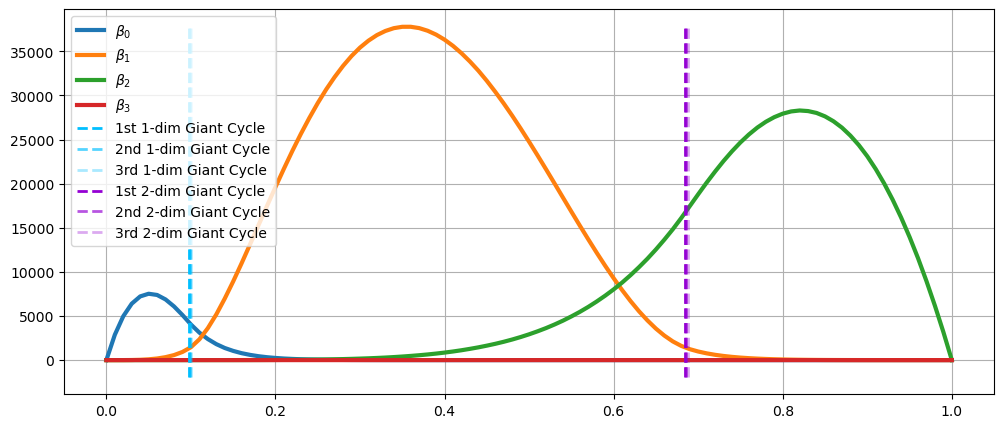

In [11]:
plt.figure(figsize=figsize)
#plt.title('Mean Persistent Betty Numbers and Giant Cycles Births\nSplitting 3-dimensional Torus by ${0}\\times{0}\\times{0}$ Cubes'.format(size))
for i in range(4):
    plt.plot(array, mean_betty[:, i], linewidth=3, label='$\\beta_{0}$'.format(i))

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = mean_betty.max() * np.array([-0.05, 1.0])
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/bettiZ3.png')

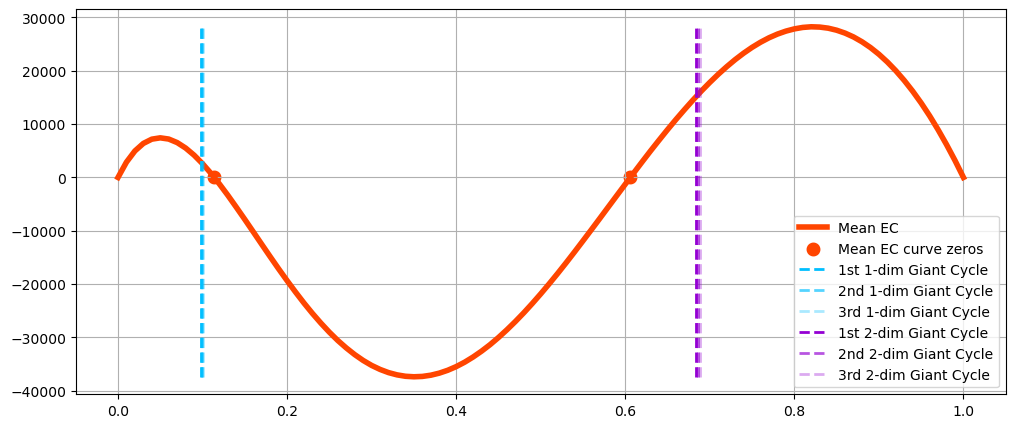

In [12]:
plt.figure(figsize=figsize)
#plt.title('Mean Euler Characteristicks and Giant Cycles Births\nSplitting 3-dimensional Torus by ${0}\\times{0}\\times{0}$ Cubes'.format(size))

mean_euler_by_sum_means = (mean_betty * (-1)**np.arange(4)).sum(axis=1)

#plt.plot(array, mean_euler_by_sum_means, color='orangered', linewidth=4, label='Mean EC by mean Betty')
plt.plot(array, mean_EC, color='orangered', linewidth=4, label='Mean EC')
plt.scatter(zeros_EC, 0*zeros_EC, color='orangered', linewidth=4, label='Mean EC curve zeros')

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = [mean_euler_by_sum_means.min(), mean_euler_by_sum_means.max()]
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/ecZ3.png')

# Analyze lab_voronoiD3_tessellation_on_torus3d

In [13]:
size = 27
experiments = 100
filename = 'lab-results/lab_voronoiD3_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
df = pd.read_csv(filename)
df.shape

(2845487, 4)

In [14]:
df_gc = df[df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

giant_births_dim1 = df_gc[df_gc['Dimension'] == 1][['Space', 'Birth']]
giant_births_dim1 = giant_births_dim1.sort_values(['Space', 'Birth'])
giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim1_mean = giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

giant_births_dim2 = df_gc[df_gc['Dimension'] == 2][['Space', 'Birth']]
giant_births_dim2 = giant_births_dim2.sort_values(['Space', 'Birth'])
giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim2_mean = giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': giant_births_dim2_mean}).transpose()

,0,1,2
Mean Giant Birth Dim 1,0.135780,0.138391,0.141021
Mean Giant Birth Dim 2,0.794358,0.797446,0.801073


In [15]:
giant_births_dim1_var = giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
giant_births_dim2_var = giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': giant_births_dim2_var}).transpose()

,0,1,2
Variance Giant Birth Dim 1,0.000012,0.000012,0.00001
Variance Giant Birth Dim 2,0.000014,0.000011,0.00002


In [16]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_betty = calculate_mean_betty(df, array, 4)
if (mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    births3d = np.sort(matrix, axis=-1)[:, -1]
    mean_betty[:, -1] = [(births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  3.4334 seconds.


In [17]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_EC = calculate_mean_EC(df, array)
zeros_EC = catch_zeros(array, mean_EC)
zeros_EC = zeros_EC[zeros_EC > 0]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  3.3581 seconds.


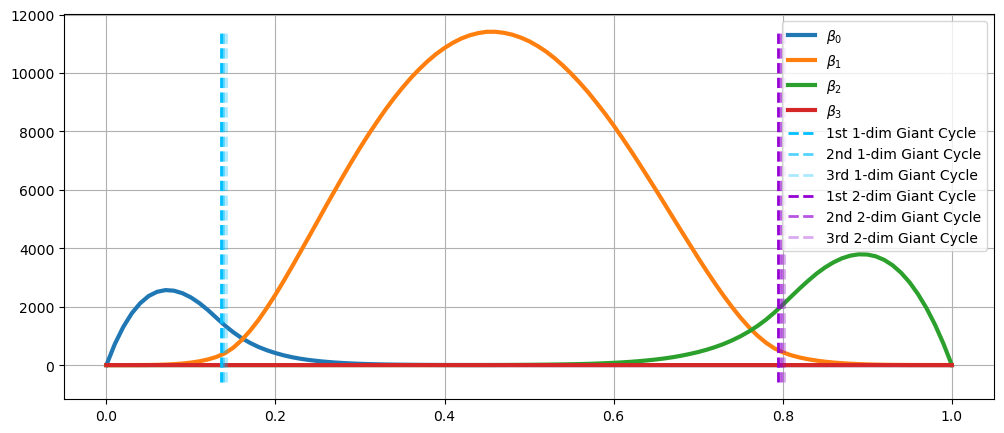

In [18]:
plt.figure(figsize=figsize)
#plt.title('Mean Persistent Betty Numbers and Giant Cycles Births\nSplitting 3-dimensional Torus by $4\cdot{0}\\times{0}\\times{0}$ $D^3$ voronoi cells'.format(size))
for i in range(4):
    plt.plot(array, mean_betty[:, i], linewidth=3, label='$\\beta_{0}$'.format(i))

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = mean_betty.max() * np.array([-0.05, 1.0])
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/bettiD3.png')

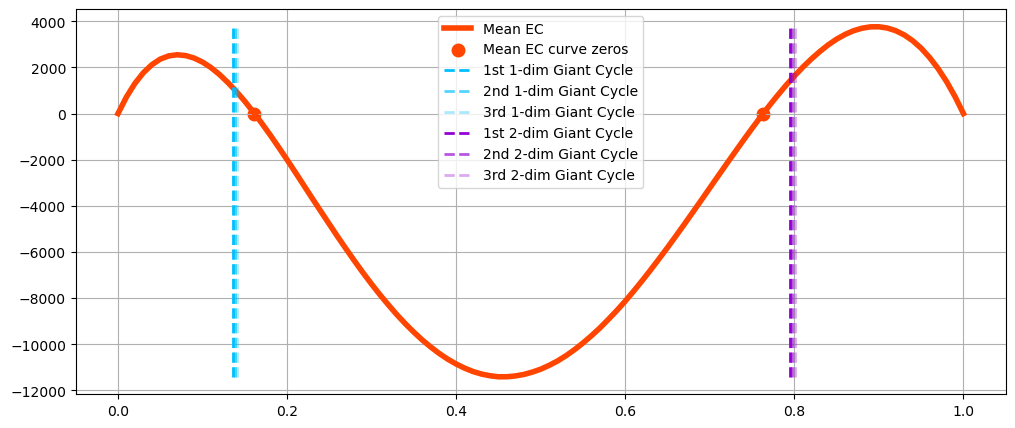

In [19]:
plt.figure(figsize=figsize)
#plt.title('Mean Euler Characteristicks and Giant Cycles Births\nSplitting 3-dimensional Torus by ${0}\\times{0}\\times{0}$ Cubes'.format(size))

mean_euler_by_sum_means = (mean_betty * (-1)**np.arange(4)).sum(axis=1)

#plt.plot(array, mean_euler_by_sum_means, color='orangered', linewidth=4, label='Mean EC by mean Betty')
plt.plot(array, mean_EC, color='orangered', linewidth=4, label='Mean EC')
plt.scatter(zeros_EC, 0*zeros_EC, color='orangered', linewidth=4, label='Mean EC curve zeros')

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = [mean_euler_by_sum_means.min(), mean_euler_by_sum_means.max()]
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/ecD3.png')

# Analyze lab_voronoiBCC_tessellation_on_torus3d

In [20]:
size = 31
experiments = 100
filename = 'lab-results/lab_voronoiBCC_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
df = pd.read_csv(filename)
df.shape

(1970942, 4)

In [21]:
df_gc = df[df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

giant_births_dim1 = df_gc[df_gc['Dimension'] == 1][['Space', 'Birth']]
giant_births_dim1 = giant_births_dim1.sort_values(['Space', 'Birth'])
giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim1_mean = giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

giant_births_dim2 = df_gc[df_gc['Dimension'] == 2][['Space', 'Birth']]
giant_births_dim2 = giant_births_dim2.sort_values(['Space', 'Birth'])
giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
giant_births_dim2_mean = giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': giant_births_dim2_mean}).transpose()

,0,1,2
Mean Giant Birth Dim 1,0.176516,0.179595,0.182610
Mean Giant Birth Dim 2,0.817094,0.820329,0.824191


In [22]:
giant_births_dim1_var = giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
giant_births_dim2_var = giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': giant_births_dim2_var}).transpose()

,0,1,2
Variance Giant Birth Dim 1,0.000017,0.000011,0.000011
Variance Giant Birth Dim 2,0.000018,0.000018,0.000023


In [23]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_betty = calculate_mean_betty(df, array, 4)
if (mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    births3d = np.sort(matrix, axis=-1)[:, -1]
    mean_betty[:, -1] = [(births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  2.1114 seconds.


In [24]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
mean_EC = calculate_mean_EC(df, array)
zeros_EC = catch_zeros(array, mean_EC)
zeros_EC = zeros_EC[zeros_EC > 0]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  2.0410 seconds.


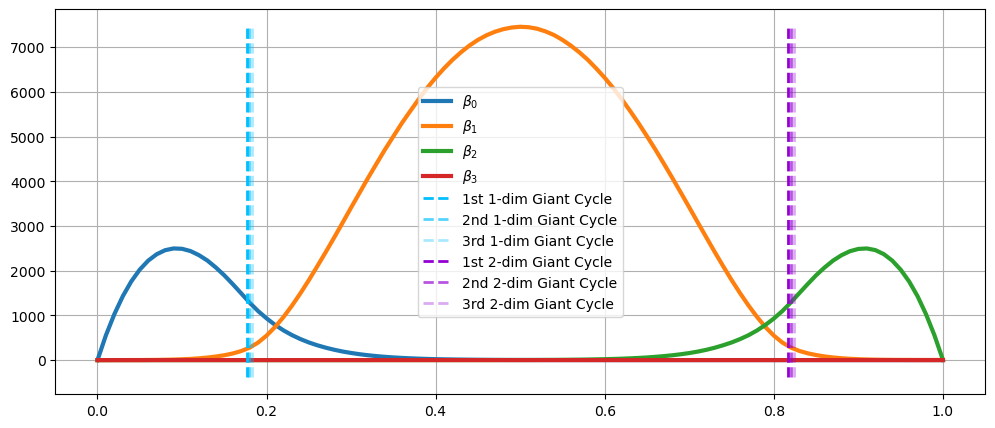

In [25]:
plt.figure(figsize=figsize)
#plt.title('Mean Persistent Betty Numbers and Giant Cycles Births\nSplitting 3-dimensional Torus by $4\cdot{0}\\times{0}\\times{0}$ $D^3$ voronoi cells'.format(size))
for i in range(4):
    plt.plot(array, mean_betty[:, i], linewidth=3, label='$\\beta_{0}$'.format(i))

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = mean_betty.max() * np.array([-0.05, 1.0])
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/bettiBCC.png')

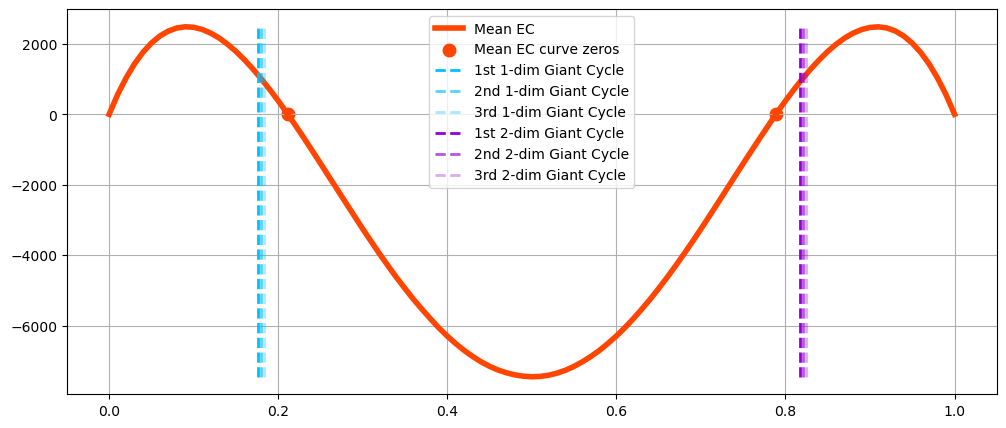

In [26]:
plt.figure(figsize=figsize)
#plt.title('Mean Euler Characteristicks and Giant Cycles Births\nSplitting 3-dimensional Torus by ${0}\\times{0}\\times{0}$ Cubes'.format(size))

mean_euler_by_sum_means = (mean_betty * (-1)**np.arange(4)).sum(axis=1)

#plt.plot(array, mean_euler_by_sum_means, color='orangered', linewidth=4, label='Mean EC by mean Betty')
plt.plot(array, mean_EC, color='orangered', linewidth=4, label='Mean EC')
plt.scatter(zeros_EC, 0*zeros_EC, color='orangered', linewidth=4, label='Mean EC curve zeros')

color1d = 'deepskyblue'
color2d = 'darkviolet'
labels = ['1st {0}-dim Giant Cycle', 
          '2nd {0}-dim Giant Cycle', 
          '3rd {0}-dim Giant Cycle']
ypair = [mean_euler_by_sum_means.min(), mean_euler_by_sum_means.max()]
for i in range(3):
    plt.plot(giant_births_dim1_mean[i]*np.ones(2), ypair, color=color1d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(1))
for i in range(3):
    plt.plot(giant_births_dim2_mean[i]*np.ones(2), ypair, color=color2d, 
             alpha=1 - i/3, linestyle='--', linewidth=2, label=labels[i].format(2))
    
plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/ecBCC.png')